## Problem Statement  : 
    Anomaly detection using Transformers

NYC TAXI DATA :- Number of NYC taxi passengers, where the five anomalies occur
during the NYC marathon, Thanksgiving, Christmas, New Years day, and a snow
storm. The raw data is from the NYC Taxi and Limousine Commission.
The data file included here consists of aggregating the total number of
taxi passengers into 30 minute buckets.

Business Benefit :- Ability to detect and forecast the anomalies help reduce the cost of allocation of excess resources and help manage the sudden increase in the demand as well to make the management efficient.

## Importing Required Packages

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K
import pandas as pd
import numpy as np
import json
from sklearn import preprocessing
from pathlib import Path
import os
import matplotlib.pyplot as plt
from shutil import copyfile
import pickle
from datetime import datetime
import random

## Load Data and Visualize 


NYC Taxi Data


In [20]:
with open('combined_windows.json') as f:
    j_label = json.load(f)
j_label = {x.replace('/', '_'):y for x,y in j_label.items()}

In [21]:
def read_data(data_path=None):
    key = data_path.name
    ano_spans = j_label[key]
    ano_span_count = len(ano_spans)
    df_x = pd.read_csv(data_path)
    df_x, df_y = assign_ano(ano_spans, df_x)

    return df_x, df_y

def assign_ano(ano_spans=None, df_x=None):
    df_x['timestamp'] = pd.to_datetime(df_x['timestamp'])
    y = np.zeros(len(df_x))
    for ano_span in ano_spans:
        ano_start = pd.to_datetime(ano_span[0])
        ano_end = pd.to_datetime(ano_span[1])
        for idx in df_x.index:
            if df_x.loc[idx, 'timestamp'] >= ano_start and df_x.loc[idx, 'timestamp'] <= ano_end:
                y[idx] = 1.0
                
    return df_x, pd.DataFrame(y)


In [22]:
df_x, df_y = read_data(Path('realKnownCause_nyc_taxi.csv'))

In [23]:
hrs = ['hours_' + str(i) for i in range(24)]
dow = ['DayOfTheWeek_' + str(i) for i in range(7)]
wkd = ['WeekDay_' + str(i) for i in range(2)]
daylight = ['daylight_' + str(i) for i in range(2)]
wk = ['Week_' + str(i) for i in range(53)]
times = [hrs, dow, wkd, daylight, wk]

In [24]:
def prep(dfx):
    df = dfx.copy()
    scaler = preprocessing.StandardScaler()
    df['hours'] = df['timestamp'].dt.hour
    df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)
    df['hours'] = df['hours'].astype(str)
    df['daylight'] = df['daylight'].astype(str)
    # the day of the week (Monday=0, Sunday=6) and if it's a week end day or week day.
    df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
    df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)
    df['DayOfTheWeek'] = df['DayOfTheWeek'].astype(str)
    df['WeekDay'] = df['WeekDay'].astype(str)

    # the week of the year
    df['Week'] = df['timestamp'].dt.week
    df['Week'] = df['Week'].astype(str)

    df['value'] = scaler.fit_transform(df[['value']])
    df['timestamp'] = df['timestamp'].astype(np.int64)
    df = pd.get_dummies(df) 
    c = df.columns.tolist()
    for t in times:
        for i in t:
            if i not in c:
                df[i] = 0
    
    return df, scaler

In [25]:
df_x2, scaler = prep(df_x)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  from ipykernel import kernelapp as app


In [26]:
df_x2['timestamp'] /= 1e10

In [27]:
#df_x2.head()

In [28]:
# create sequences 
def unroll(data, labels, window_length=None, stride=1):
    un_data = []
    un_labels = []
    seq_len = int(window_length) if window_length else min(30, int(len(data)*.01))
    stride = int(stride)
    idx = 0
    while(idx < len(data) - seq_len):
        un_data.append(np.array(data.iloc[idx:idx+seq_len]))
        un_labels.append(np.array(labels.iloc[idx:idx+seq_len]))
        idx += stride
    return np.array(un_data), np.squeeze(np.array(un_labels)), seq_len

In [76]:
wl = 100
ml = 7

In [77]:
def data_prep(df_x2, df_y, wl, ml):
  a,b,seq_len = unroll(df_x2, df_y, wl)
  indx1 = [i for i in range(len(b)) if sum(b[i])>0]
  indx2 = [i for i in range(len(b)) if sum(b[i])==0]
  random.shuffle(indx1)
  random.shuffle(indx2)
  l = len(indx1) ; m = len(indx2)
  m = ml*l
  trn, val, tst = indx1[:l//2] + indx2[:m//2], indx1[l//2:-l//4] + indx2[m//2:-m//4], indx1[-l//4:] + indx2[-m//4:]
  return a[trn] , a[val] , a[tst] , b[trn] , b[val] , b[tst]

In [78]:
  trn_x , val_x, tst_x, trn_y , val_y , tst_y  = data_prep(df_x2, df_y, wl, ml)


In [162]:
a,b,seq_len = unroll(df_x2, df_y, wl)

### Data Viz 

NYC Taxi Data 

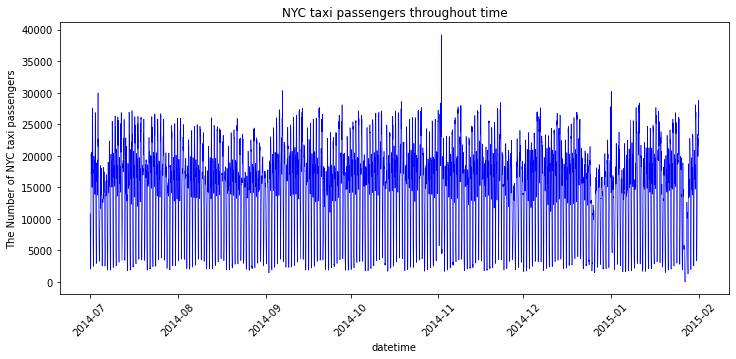

In [32]:
# change the type of timestamp column for plotting

# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(df_x['timestamp'], df_x['value'], color='blue', linewidth=0.6)
ax.set_title('NYC taxi passengers throughout time')

plt.xlabel('datetime')
plt.xticks(rotation=45) 
plt.ylabel('The Number of NYC taxi passengers')
plt.show()

Anomaly Visualization 

In [35]:
anom = j_label['realKnownCause_nyc_taxi.csv']

In [49]:
start = df_x[df_x['timestamp']==anom[0][0]].index[0]
end = df_x[df_x['timestamp']==anom[0][1]].index[0]


In [57]:
ano_df = df_x[start:end]
ano_df_win = df_x[start-wl:end+wl]

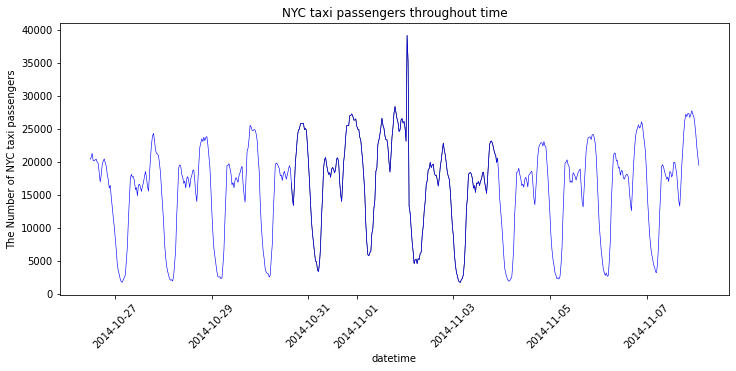

In [60]:
# change the type of timestamp column for plotting

# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(ano_df['timestamp'], ano_df['value'], color='black', linewidth=0.6)
ax.plot(ano_df_win['timestamp'], ano_df_win['value'], color='blue', linewidth=0.6)
ax.set_title('NYC taxi passengers throughout time')

plt.xlabel('datetime')
plt.xticks(rotation=45) 
plt.ylabel('The Number of NYC taxi passengers')
plt.show()

## Implement Transformer Model

### Implement multi head self attention as a Keras layer




In [12]:

class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output



### Implement a Transformer block as a layer



In [13]:

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)



## Build Model


In [144]:

embed_dim = 90  # Feature size for each TS
num_heads = 5  # Number of attention heads
ff_dim = 8 # Hidden layer size in feed forward network inside transformer
d_dim = 40
dropout_rate = 0.4
sl = wl


In [145]:
# hyper_params = {'num_heads':[1,2,5,9,10],
#                 'ff_dim' : [2,4,8,16,20,24,32,40],
#                 'd_dim': [2,3,4,5,6,7,8,9],
#                 'dropout_rate' : [.1, .2, .3, .4, .5, .6, .7, .8],
#                 'sl' : [5,10,20,50,80,100,200,500],
#                 'ml' : [2,5,8]
#                 }

In [147]:
### Metrics Definition  ###

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2*((prec*rec)/(prec+rec+K.epsilon()))


In [156]:
def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1) + 0.02*tf.keras.losses.BinaryCrossentropy(from_logits=False, label_smoothing=0, reduction="auto")(y_true, y_pred)

In [157]:
def m(embed_dim, num_heads, ff_dim, d_dim, dropout_rate, seq_len):
  inputs = layers.Input(shape=(seq_len,embed_dim))
  transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim, dropout_rate)
  x = transformer_block(inputs)
  x = layers.Dropout(dropout_rate)(x)
  x = layers.Dense(d_dim, activation="relu")(x)
  x = layers.Dropout(dropout_rate)(x)
  outputs = layers.Dense(1, activation='sigmoid')(x)
  model = keras.Model(inputs=inputs, outputs=outputs)
  ###   Compile the model   ###
  model.compile(optimizer='adam', loss=f1_loss, metrics=['acc',f1,precision, recall])
  return model

model = m(embed_dim, num_heads, ff_dim, d_dim, dropout_rate, wl)

In [158]:
model.summary()

Model: "functional_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 100, 90)]         0         
_________________________________________________________________
transformer_block_15 (Transf (None, 100, 90)           34658     
_________________________________________________________________
dropout_62 (Dropout)         (None, 100, 90)           0         
_________________________________________________________________
dense_126 (Dense)            (None, 100, 40)           3640      
_________________________________________________________________
dropout_63 (Dropout)         (None, 100, 40)           0         
_________________________________________________________________
dense_127 (Dense)            (None, 100, 1)            41        
Total params: 38,339
Trainable params: 38,339
Non-trainable params: 0
_________________________________________________

In [163]:
history = model.fit(
    a, b, batch_size=64, epochs=10, validation_data=(val_x, val_y)
)

Epoch 1/10
160/160 [==============================] - 2s 12ms/step - loss: 0.8473 - acc: 0.1100 - f1: 0.1821 - precision: 0.1013 - recall: 0.9895 - val_loss: 0.7827 - val_acc: 0.2518 - val_f1: 0.2857 - val_precision: 0.2405 - val_recall: 0.3529
Epoch 2/10
160/160 [==============================] - 2s 11ms/step - loss: 0.8474 - acc: 0.1060 - f1: 0.1819 - precision: 0.1012 - recall: 0.9938 - val_loss: 0.7815 - val_acc: 0.2518 - val_f1: 0.2857 - val_precision: 0.2405 - val_recall: 0.3529
Epoch 3/10
160/160 [==============================] - 2s 11ms/step - loss: 0.8470 - acc: 0.1061 - f1: 0.1822 - precision: 0.1013 - recall: 0.9943 - val_loss: 0.7806 - val_acc: 0.2518 - val_f1: 0.2857 - val_precision: 0.2405 - val_recall: 0.3529
Epoch 4/10
160/160 [==============================] - 2s 12ms/step - loss: 0.8476 - acc: 0.1073 - f1: 0.1817 - precision: 0.1012 - recall: 0.9926 - val_loss: 0.7770 - val_acc: 0.2518 - val_f1: 0.2857 - val_precision: 0.2405 - val_recall: 0.3529
Epoch 5/10
160/160 [

## Test the model and Vizualize Results

In [161]:
model.evaluate(tst_x, tst_y)

96/96 [==============================] - 1s 5ms/step - loss: 0.9402 - acc: 0.0852 - f1: 0.1008 - precision: 0.0849 - recall: 0.1250


[0.9402163624763489,
 0.0851747915148735,
 0.10080515593290329,
 0.08486980199813843,
 0.125]

## Conclusion and Future Scope

Successfully used transformer concept and architecture to model the time series data in order to identify the anomalies in the NYC taxi data.​

​

However, the performance of the model is not acceptable at this point of time as Vanilla architecture Transformer has been used.​

​

More complex transformer architectures in combination with LSTM and bidirectional RNNs can be used to improve performance.​

​

Hyperparameter tuning could also be implemented to improve the model.

## Grid Search For Model Tuning

In [ ]:
# ###  GRID SEARCH FOR BEST HYPER-PARAMS  ###
# embed_dim = 90
# hs = []
# hps = []
# for i in range(10):
#   hp = random.choice(hyper_params['sl']), random.choice(hyper_params['ml']), random.choice(hyper_params['num_heads']), random.choice(hyper_params['ff_dim']), random.choice(hyper_params['d_dim']), random.choice(hyper_params['dropout_rate'])

#   hps.append(hp)

#   trn_x , val_x, tst_x, trn_y , val_y , tst_y  = data_prep(df_x2, df_y, hp[0], hp[1])

#   model = m(embed_dim , hp[2], hp[3], hp[4], hp[5], hp[0])

#   history = model.fit(trn_x, trn_y, batch_size=100, epochs=50, validation_data=(val_x, val_y) , verbose=0)
  
#   hs.append(history)
#   print(i)


In [ ]:
# val_f1_s = [h.history['val_f1'] for h in hs]
# val_f1_best = max(val_f1_s)

In [ ]:
#hps[val_f1_s.index(val_f1_best)]

In [ ]:
#val_f1_best

In [ ]:
(50, 2, 2, 24, 3, 0.2)
(5, 2, 9, 40, 8, 0.1)
